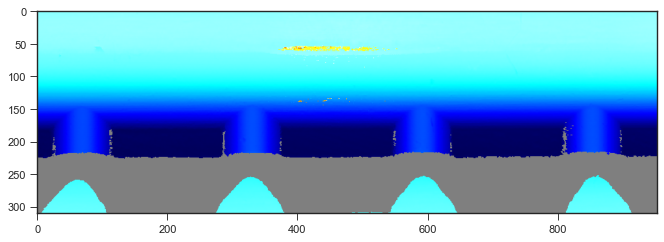

In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import math
from skimage import data
from skimage.filters import threshold_otsu
from matplotlib import style
style.use('seaborn-ticks')

im = cv.imread(r'I:\220331\img\2.png')
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
figure(figsize = (10, 6), dpi=80)
plt.imshow(im)


# Tooth extraction

133 393


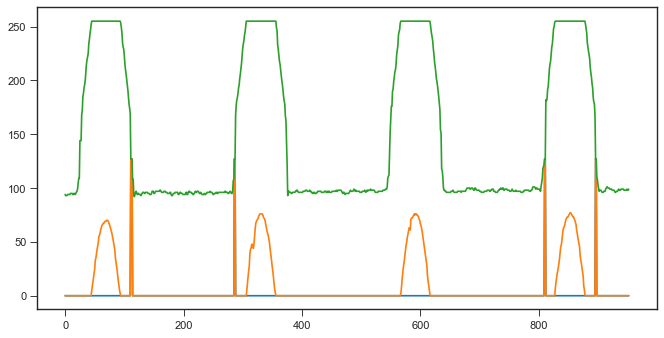

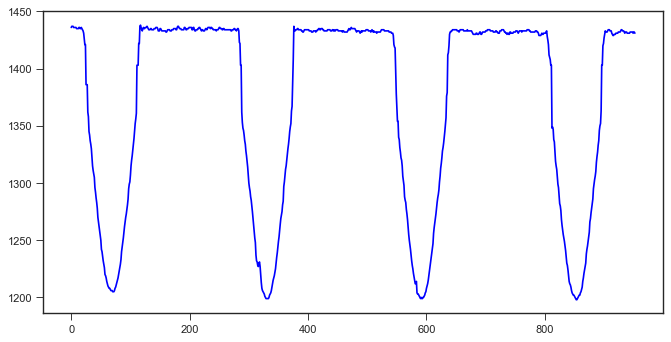

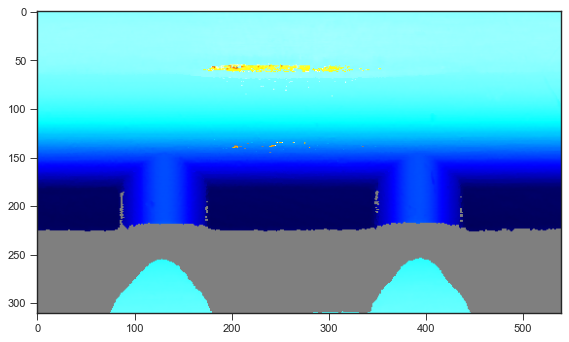

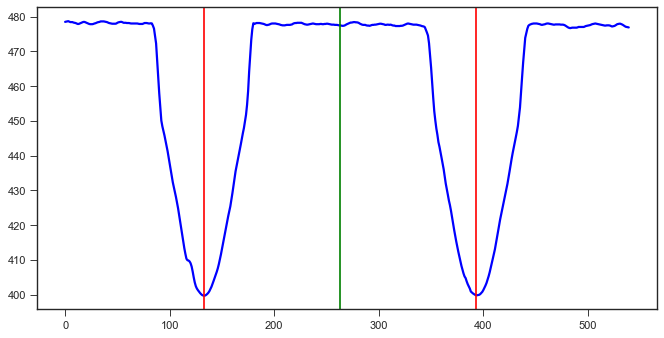

In [2]:

reference_line = im[200,:]
figure(figsize = (10, 5), dpi=80)
plt.plot(reference_line)

section = []
for i,v in enumerate(reference_line):
    r,g,b = reference_line[i]
    if(r>0):
        r=0
        b=0
    
    if(r == 255 or (b) == 0 and g == 0):
        section.append((int)(r) + (int)(g) + (int)(b))  
    else:
        section.append(6*255 - r - g - b)

figure(figsize = (10, 5), dpi=80)
plt.plot(section,c='b')

from scipy.signal import lfilter
n = 5  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 3
section = lfilter(b,a,section)

im = im[:,200:740]
figure(figsize = (10, 5), dpi=80)
plt.imshow(im)

section = section[200:740]
figure(figsize = (10, 5), dpi=80)
plt.plot(section, linewidth=2, linestyle="-", c="b")  # smooth by filter
section1 = section[0:270]
section2 = section[270:540]
border = np.argmin(section1), np.argmin(section2)+270
plt.axvline(x=border[0],c='r')
plt.axvline(x=border[1],c='r')
split = int((border[0]+border[1])/2)
plt.axvline(x=split,c='g')
print(border[0],border[1])



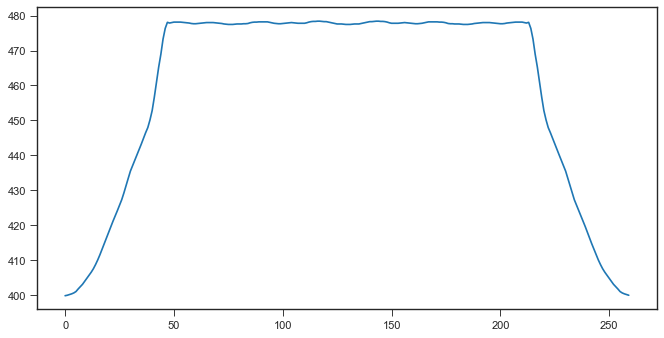

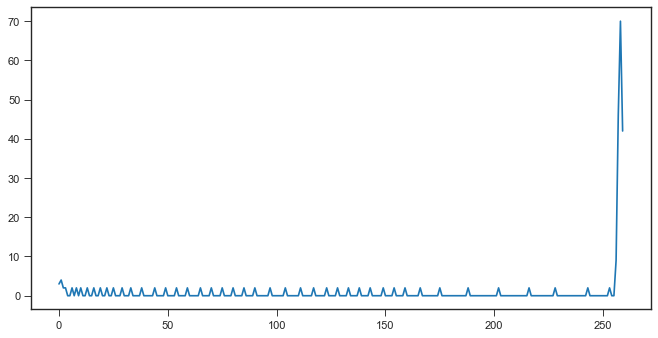

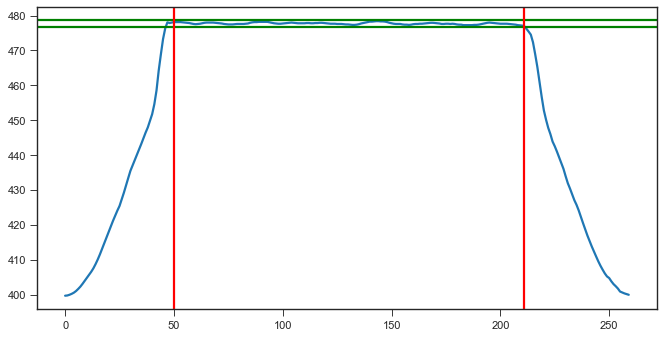

In [3]:

values = []
true_values = []
for i in range(0,border[1]-border[0]):
    true_values.append(section[border[0]+i])
    if(section[border[0]+i] > section[border[1]-i]):
        values.append(section[border[0]+i])
    else:
        values.append(section[border[1]-i])

figure(figsize = (10, 5), dpi=80)
plt.plot(values)  

combine_hist = 1
hist, bins = np.histogram(values, bins = int(len(values)/combine_hist))

figure(figsize = (10, 5), dpi=80)
plt.plot(hist)

roof = np.where(hist==(max(hist)))[0][0]
roof = bins[roof]
offest = 1
start, stop = 0, 0
for i in range(len(values)):
    if values[i]>roof-offest: 
        start = i+3
        break
for i in range(len(values)):
    if values[len(values)-i-1]>roof-offest: 
        stop = len(values)-i-3
        break

figure(figsize = (10, 5), dpi=80)
plt.plot(true_values,linewidth=2)  
plt.axhline(y=roof-offest,c='g',linewidth=2)
plt.axhline(y=roof+offest,c='g',linewidth=2)
plt.axvline(x=start,c='r',linewidth=2)
plt.axvline(x=stop,c='r',linewidth=2)

start_x = start+border[0]
stop_x = stop+border[0]

In [4]:
'''
tooth_top = true_values[start:stop]
figure(figsize = (10, 5), dpi=80)
plt.plot(tooth_top,linewidth=2)  
plt.axhline(y=roof,c='g',linewidth=2)

tooth_top = tooth_top - roof
figure(figsize = (10, 5), dpi=80)
plt.grid()
plt.plot(tooth_top,linewidth=2)  
plt.axhline(y=-0.5,c='m',linewidth=2)
plt.axhline(y=min(tooth_top),c='r',linewidth=2)

failure_max_depth = min(tooth_top)
failure_width = tooth_top
'''

"\ntooth_top = true_values[start:stop]\nfigure(figsize = (10, 5), dpi=80)\nplt.plot(tooth_top,linewidth=2)  \nplt.axhline(y=roof,c='g',linewidth=2)\n\ntooth_top = tooth_top - roof\nfigure(figsize = (10, 5), dpi=80)\nplt.grid()\nplt.plot(tooth_top,linewidth=2)  \nplt.axhline(y=-0.5,c='m',linewidth=2)\nplt.axhline(y=min(tooth_top),c='r',linewidth=2)\n\nfailure_max_depth = min(tooth_top)\nfailure_width = tooth_top\n"

# Tooth extraction cd

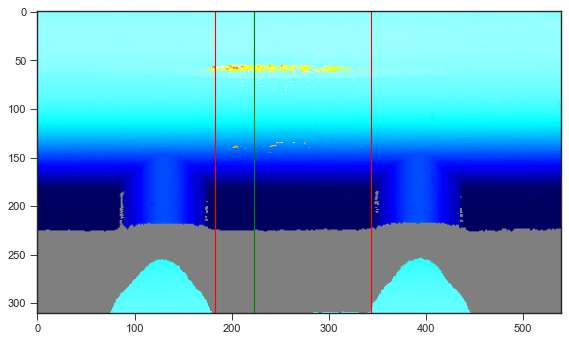

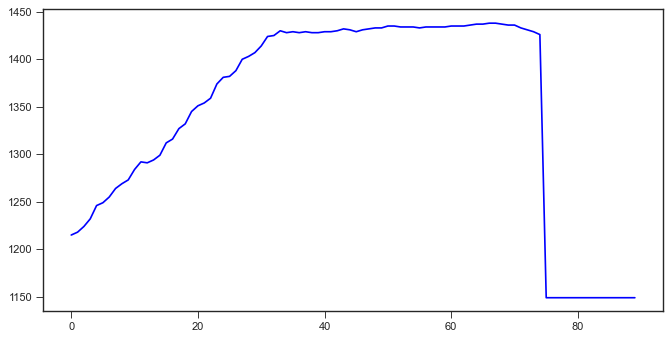

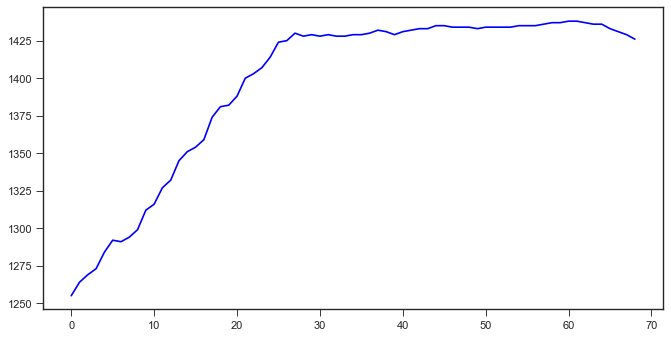

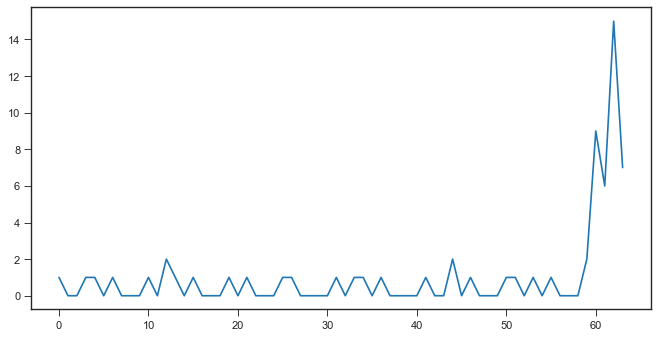

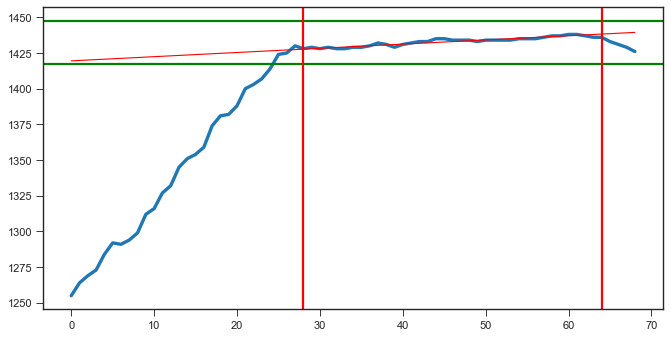

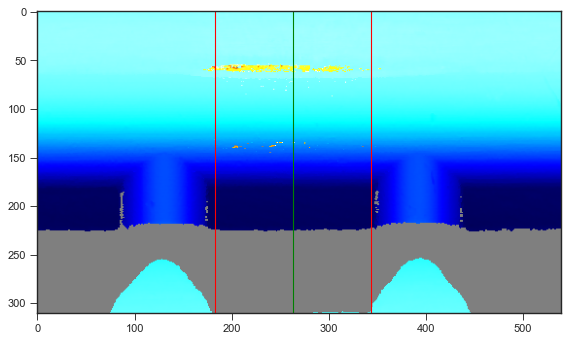

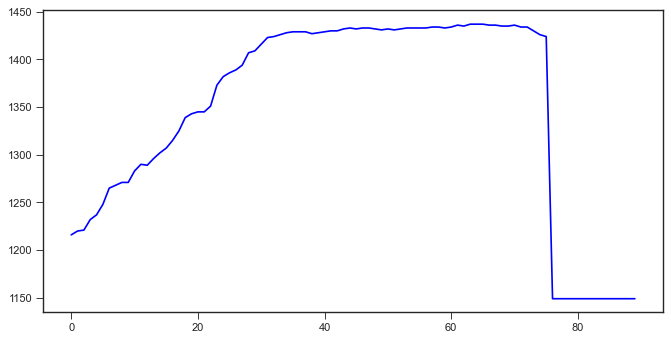

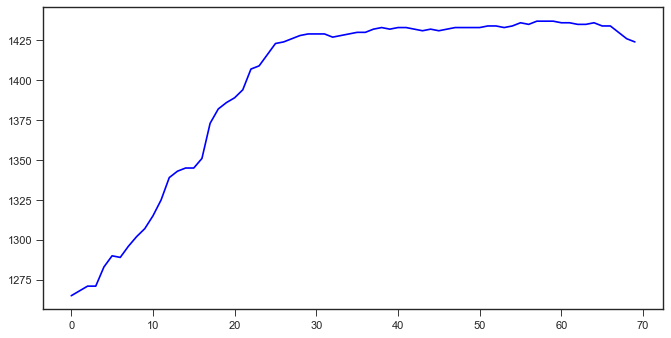

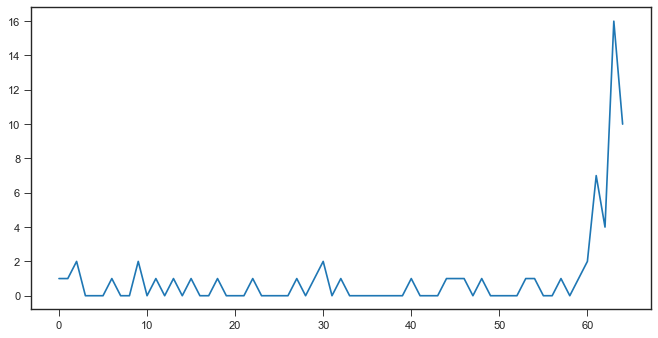

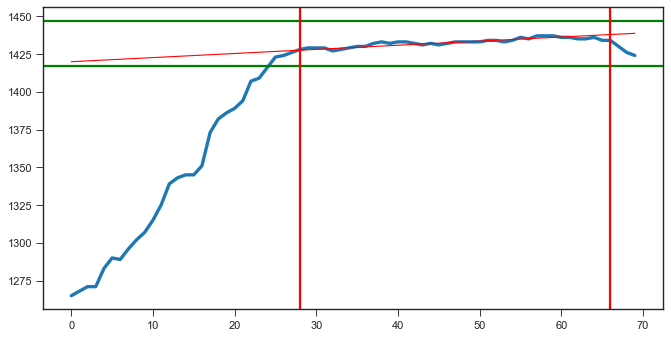

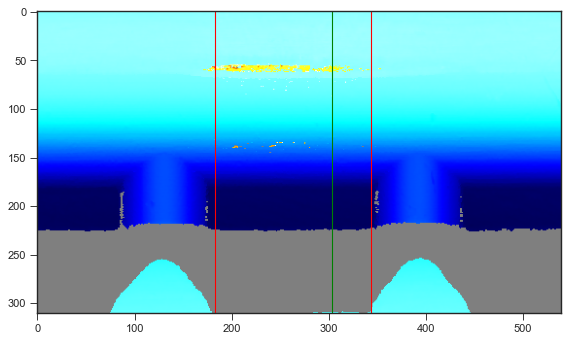

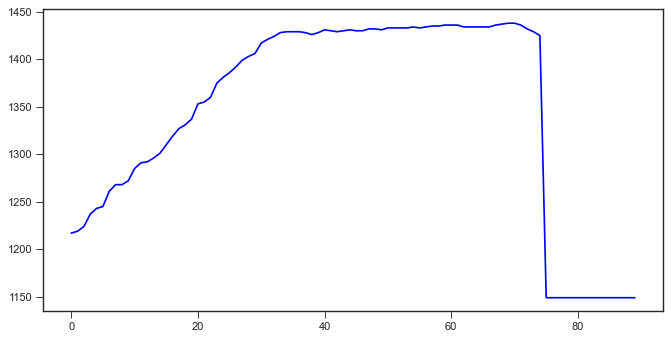

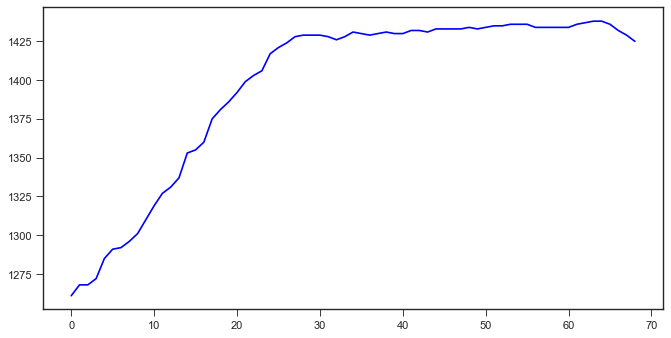

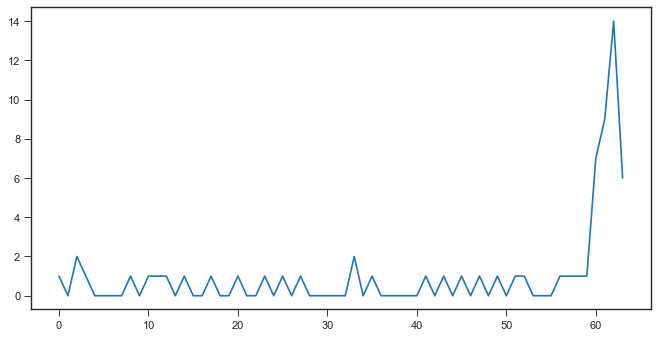

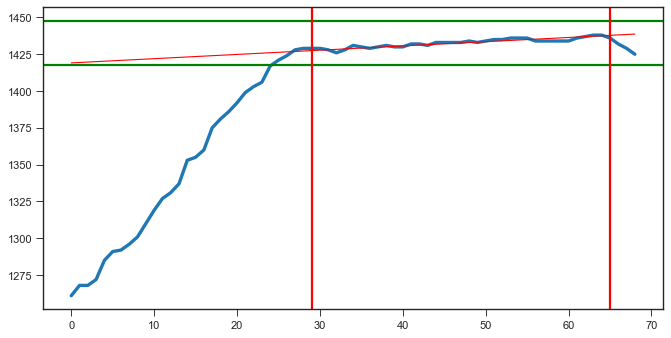

In [5]:
def find_y_limits(reference_line):
    section = []
    for i,v in enumerate(reference_line):
        r,g,b = reference_line[i]
        
        if(r == 255 or (b) == 0 and g == 0):
            section.append((int)(r) + (int)(g) + (int)(b))  
        else:
            section.append(6*255 - r - g - b)

    figure(figsize = (10, 5), dpi=80)
    plt.plot(section,c='b')

    filtred_section = []
    for s in section:
        if s>1250: filtred_section.append(s)
    filtred_section2=filtred_section[0:-5]

    figure(figsize = (10, 5), dpi=80)
    plt.plot(filtred_section,c='b')

    combine_hist = 1
    hist, bins = np.histogram(filtred_section2, bins = int(len(filtred_section2)/combine_hist))

    figure(figsize = (10, 5), dpi=80)
    plt.plot(hist)

    roof = np.where(hist==(max(hist)))[0][0]
    roof = bins[roof]
    offest = 15

    figure(figsize = (10, 5), dpi=80)
    plt.plot(filtred_section,linewidth=3)  
    plt.axhline(y=roof-offest,c='g',linewidth=2)
    plt.axhline(y=roof+offest,c='g',linewidth=2)

    x,y=[],[]
    for i in range(len(filtred_section2)):
        if filtred_section2[i] > roof-offest and filtred_section2[i] < roof+offest:
            x.append(i)
            y.append(filtred_section2[i])

    a, b = np.polyfit(x, y, 1)
    x,y = [],[]
    for i in range (len(filtred_section)):
        x.append(i)
        y.append(a*i+b)

    plt.plot(x,y,c='r',linewidth=1)  

    start_y, stop_y = 0, 0
    for i in range(len(filtred_section)):
        if abs(filtred_section[i] - (a*x[i]+b)) < 5: 
            start_y = i+3
            break
    for i in range(len(filtred_section)):
        if abs(filtred_section[len(filtred_section)-i-1] - (a*x[len(filtred_section)-i-1]+b)) < 5: 
            stop_y = len(filtred_section)-i-1
            break
    plt.axvline(x=start_y,c='r',linewidth=2)
    plt.axvline(x=stop_y,c='r',linewidth=2)
    return a,b,start_y,stop_y

width = stop-start 
sections = [split - int(width/4), split, split +  int(width/4)]
params_y = []
for s in sections:
    reference_line = im[150:240,s]

    figure(figsize = (10, 5), dpi=80)
    plt.axvline(x=start_x,c='r',linewidth=1)
    plt.axvline(x=stop_x,c='r',linewidth=1)
    plt.axvline(x=s,c='g',linewidth=1)
    plt.imshow(im)

    params_y.append(find_y_limits(reference_line))

# Extraction results

(0.2724202626641599, 1419.877298311445, 28, 66)


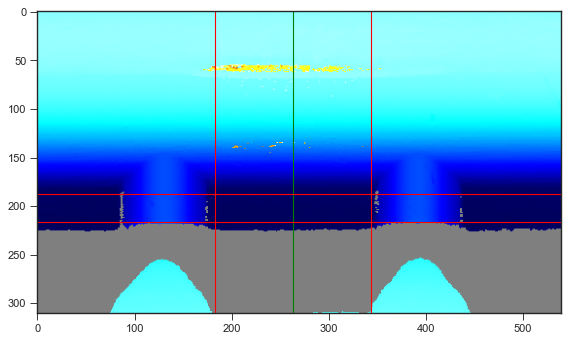

In [6]:
best_params_y = params_y[0]
for p in params_y:
    if p[3]>best_params_y[3]:best_params_y=p
  
print(best_params_y)
a,b,start_y,stop_y = best_params_y
start_y+=10

figure(figsize = (10, 5), dpi=80)
plt.axvline(x=start_x,c='r',linewidth=1)
plt.axvline(x=stop_x,c='r',linewidth=1)
plt.axvline(x=split,c='g',linewidth=1)
plt.axhline(y=start_y+150,c='r',linewidth=1)
plt.axhline(y=stop_y+150,c='r',linewidth=1)
plt.imshow(im)

# Results

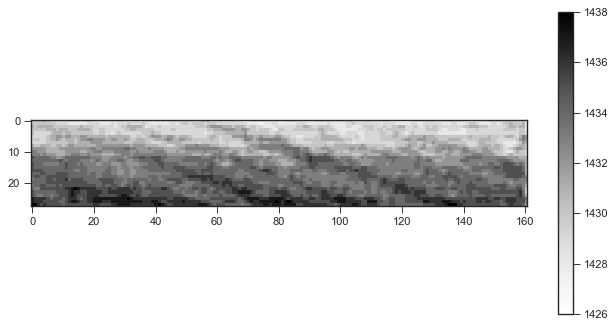

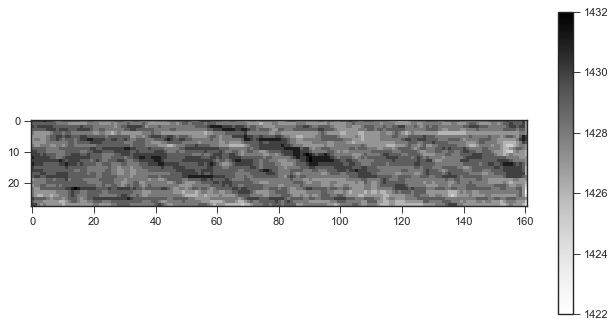

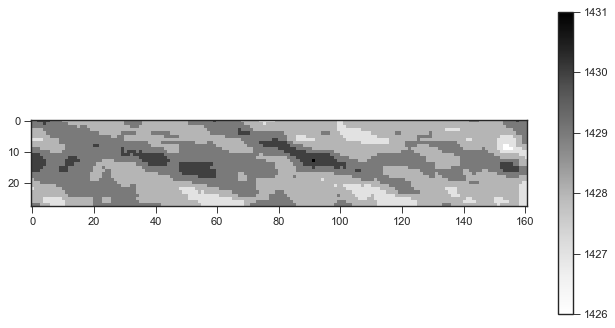

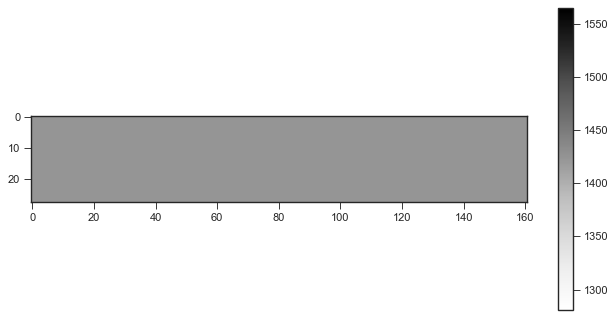

In [7]:
import cv2 as cv
import statistics


figure(figsize = (10, 5), dpi=80)
roi=im[start_y+150:stop_y+150,start_x:stop_x]
r,g,b = cv.split(roi)
sx,sy = r.shape
sum1 = np.zeros(shape=[sx, sy, 1], dtype=np.uint16)

for x in range(sx):
    for y in range(sy):

        if(r[x,y] == 255 or (b[x,y]) == 0 and g[x,y] == 0):
            sum1[x,y] = (int)(r[x,y]) + (int)(g[x,y]) + (int)(b[x,y])  
        else:
            sum1[x,y] = 6*255 - r[x,y] - g[x,y] - b[x,y]

plt.imshow(sum1)
plt.colorbar()

a,b,start_y,stop_y = best_params_y
for x in range(sx):
    for y in range(sy):
        sum1[x][y]=sum1[x][y]-a*x

def flatten(t):
    return [item for sublist in t for item in sublist]


figure(figsize = (10, 5), dpi=80)
plt.imshow(sum1)
plt.colorbar()

sum1v = flatten(sum1)
reference = statistics.median(sum1v)

figure(figsize = (10, 5), dpi=80)
kernel = (5, 5)
sum1 = cv.blur(sum1, kernel) 
plt.imshow(sum1)
plt.colorbar()

figure(figsize = (10, 5), dpi=80)
ret, thresh = cv.threshold(sum1, int(reference)-5, np.amax(sum1), cv.THRESH_TRUNC)
plt.imshow(thresh)
plt.colorbar()



In [8]:
print("Tooth area:",thresh.shape[0]*thresh.shape[1])
max_failure = int(reference - np.amin(sum1))
piksel_defects = 0
for x in range(thresh.shape[0]):
    for y in range(thresh.shape[1]):
        if(thresh[x][y]<int(reference)-5):piksel_defects += 1

print("Piksel defects:",piksel_defects)
percentage = 100*round(piksel_defects/(thresh.shape[0]*thresh.shape[1]),1)
print(percentage,'%')
if(percentage>5):
    print("Failure depth:",max_failure*20/1000,'mm')
else:
    print("No defects")


Tooth area: 4508
Piksel defects: 0
0.0 %
No defects


# Old solution

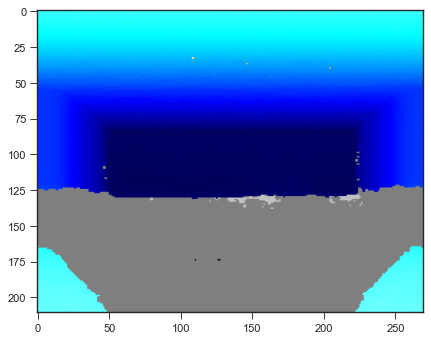

In [9]:
im = cv.imread(r'I:\220331\img\9.png')
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
roi = im[100:im.shape[0],330:600]
figure(figsize = (10, 5), dpi=80)
plt.imshow(roi)

Max value on the image: 1529


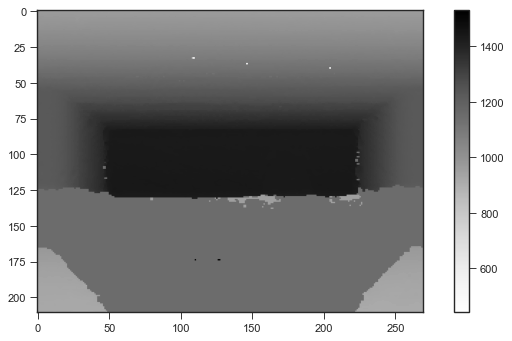

In [10]:
r,g,b = cv.split(roi)
sx,sy = r.shape
sum1 = np.zeros(shape=[sx, sy, 1], dtype=np.uint16)

for x in range(sx):
    for y in range(sy):

        if(r[x,y] == 255 or (b[x,y]) == 0 and g[x,y] == 0):
            sum1[x,y] = (int)(r[x,y]) + (int)(g[x,y]) + (int)(b[x,y])  
        else:
            sum1[x,y] = 6*255 - r[x,y] - g[x,y] - b[x,y]
                
figure(figsize = (10, 5), dpi=80)
plt.imshow(sum1)
plt.colorbar()
filtered = sum1[sum1 > 0]

print("Max value on the image:",sum1[:].max() ) 
max_val = sum1[:].max()


[151 198 241 278]
Last peak: 1390


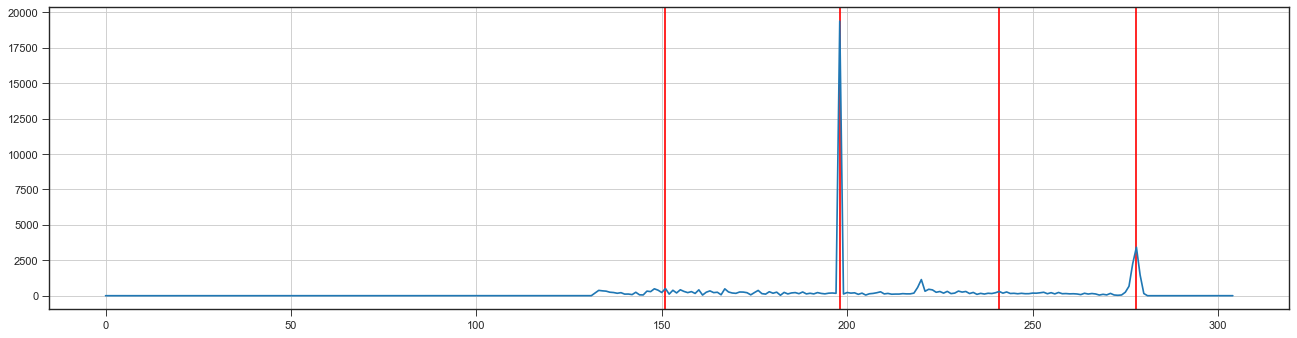

In [11]:
import numpy as np 
from scipy.signal import find_peaks

combine_hist = 5
hist, bins = np.histogram(filtered,bins = int(max_val/combine_hist))

peaks, props = find_peaks(hist,threshold=30,distance=35)
print(peaks)

figure(figsize = (20, 5), dpi=80)
for peak in peaks:
    plt.axvline(peak,color='red')
plt.grid(True)
plt.plot(hist)


print("Last peak:",peaks[-1]*combine_hist)
i = peaks[-1]*combine_hist


Range: 1380 1400


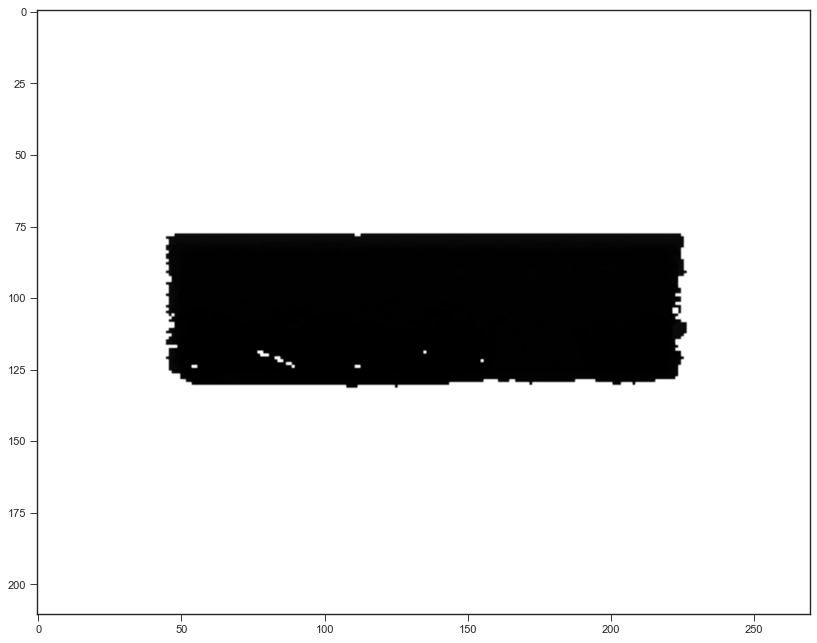

In [12]:
tresh = 10
tresh_asymetry = 5

print("Range:",i-tresh,i+tresh)
for x in range(sx):
    for y in range(sy):
        if sum1[x][y]> i+tresh*tresh_asymetry or sum1[x][y]< i-tresh: sum1[x][y]=0

figure(figsize = (20, 10), dpi=80)
plt.imshow(sum1)

In [13]:
def flatten(t):
    return [item for sublist in t for item in sublist]

sum1v = flatten(sum1)
sum2v = []
for v in sum1v:
    if v>0: sum2v.append(int(v)) 

scale_min = min(sum2v)
scale_max = max(sum2v)
scale_range = scale_max - scale_min + 50

In [14]:
for x in range(sum1.shape[0]):
    for y in range(sum1.shape[1]):
        v = sum1[x][y]
        if(v>0):
            sum1[x][y] = int((v - scale_min)/scale_range*1400)

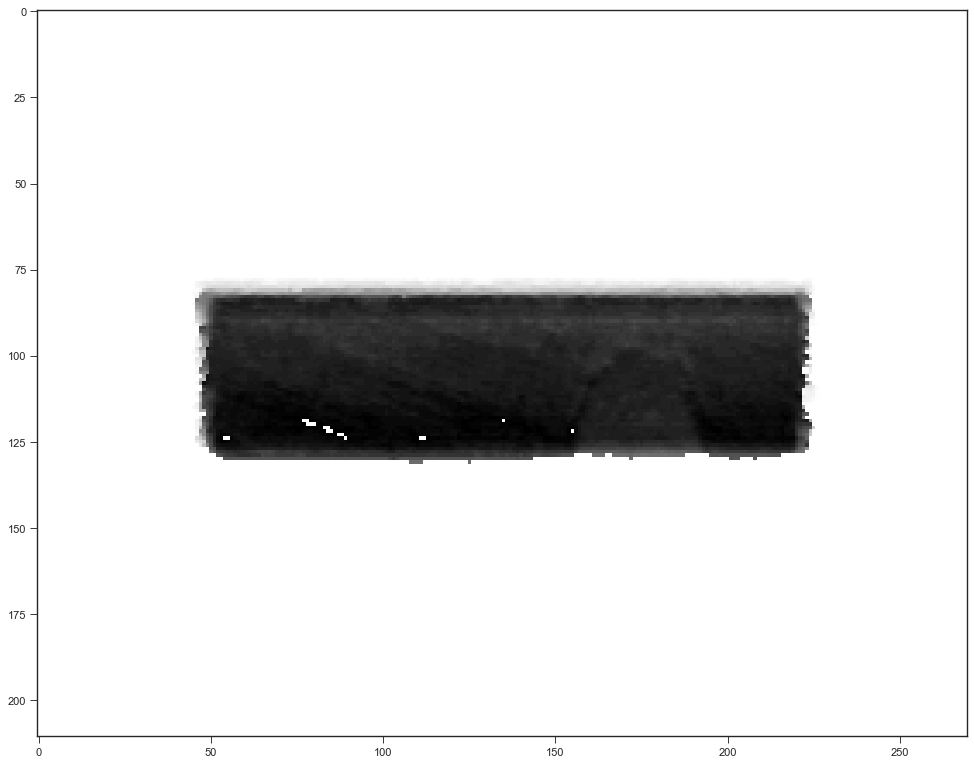

In [15]:
figure(figsize = (15, 15), dpi=80)
plt.imshow(sum1)

In [16]:
from skspatial.objects import Plane

points = []
for x in range(sum1.shape[0]):
    for y in range(sum1.shape[1]):
        if int(sum1[x][y])>0: points.append([x,y,int(sum1[x][y])])
fitted_plane = Plane.best_fit(points)
p0 = fitted_plane.point
n = fitted_plane.normal

minv = 0
maxv = 0
for x in range(sum1.shape[0]):
    for y in range(sum1.shape[1]):
        if int(sum1[x][y])>0: 
            p = (x,y,sum1[x,y])
            v = ((p[0]-p0[0])*n[0] + (p[1]-p0[1])*n[1] + (p[2]-p0[2])*n[2])*1000
            sum1[x][y]=v
            if v<minv: minv=v
            if v>maxv: maxv=v
            
print(minv)
print(maxv)

[-23499.35485719]
[48523.00885158]


In [17]:
for x in range(sum1.shape[0]):
    for y in range(sum1.shape[1]):
        if sum1[x][y]>0:
            sum1[x][y] = (int(sum1[x][y]) + abs(int(minv)))
            

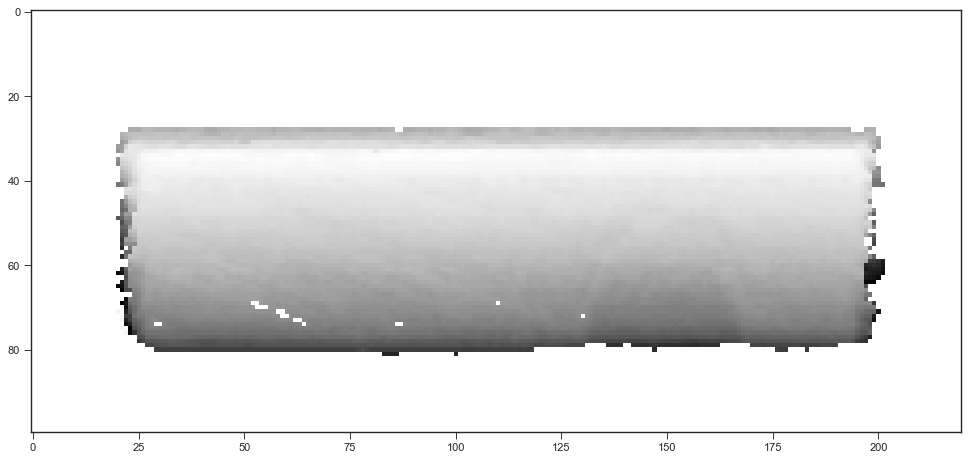

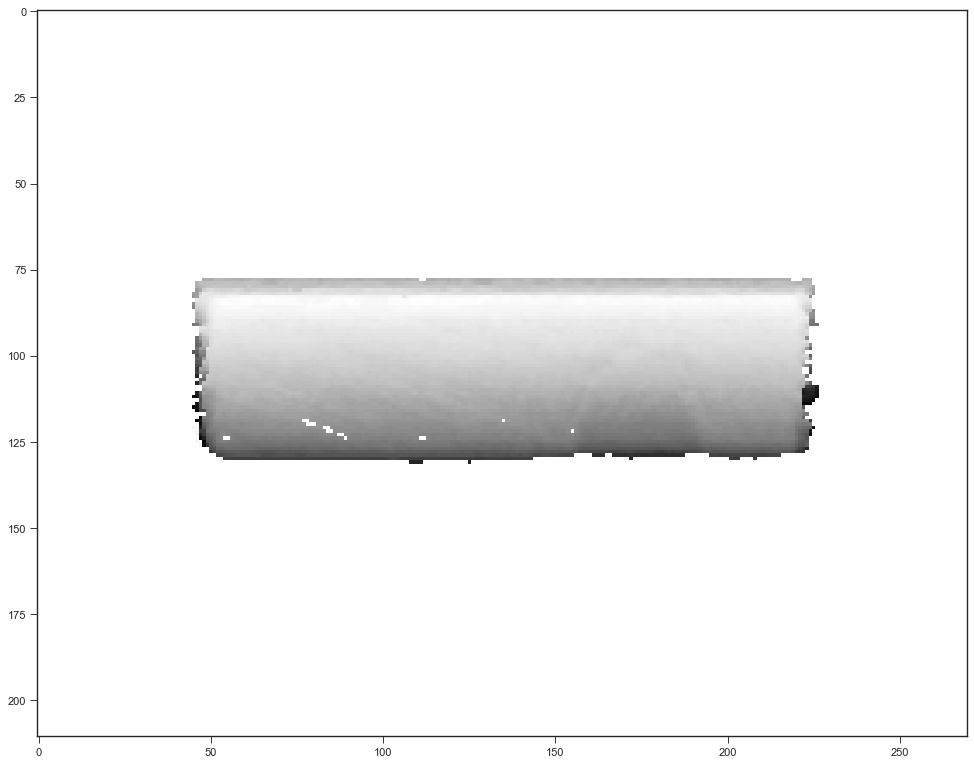

In [18]:
figure(figsize = (15, 15), dpi=80)
plt.imshow(sum1[50:150,25:245])

figure(figsize = (15, 15), dpi=80)
plt.imshow(sum1)